# Tutorial 2: Fields and Operators

This tutorials covers the basics of setting up and interacting with field and operator objects in Dedalus.

First, we'll import the public interface and suppress some of the logging messages:

In [1]:
from dedalus import public as de
import numpy as np
import matplotlib.pyplot as plt

de.logging_setup.rootlogger.setLevel('ERROR')
%matplotlib inline

## 2.1: Fields

### Creating a field

Field objects represent scalar fields defined over a domain.  A field can be directly instantiated from the `Field` class by passing a domain object, or using the `domain.new_field` method.  Let's set up a 2D domain and build a field:

In [2]:
xbasis = de.Fourier('x', 64, interval=(0,2*np.pi), dealias=3/2)
ybasis = de.Chebyshev('y', 64, interval=(-1,1), dealias=3/2)
domain = de.Domain([xbasis, ybasis], grid_dtype=np.float64, mesh=[1])
f = domain.new_field(name='f')

We also gave the field a name -- something which is automatically done for the state fields when solving a problem in Dedalus (we'll see more about this in the next notebook), but we've just done it manually, for now.

### Manipulating field data

The `layout` attribute of each field is a reference to the layout object (discussed in tutorial 1) describing the current transform/distribution state of that field's data.

In [58]:
f.layout.grid_space

array([False, False])

Field data can be written and retrieved in any layout by indexing a field a layout object.  In most cases it's just the full grid and full coefficient data that's most useful to interact with, and these layouts can be easily accessed using `'g'` and `'c'` keys as shortcuts.  Field objects also have several methods that can be used to convert the data between layouts.

Remember that when accessing field data, you're manipulating just the local data of the globally distributed dataset.  Details about the data distribution are available through methods on the layout objects.

Let's assign our field some data using the local domain grids.

In [54]:
x, y = domain.grids(scales=1)
# Set data in grid space using 'g' key
f['g'] = x*x-y*y+2*x-10*y
print(f['g'].shape)

(64, 64)


And let's take a look at this data using some helper functions from the `plot_tools` module.

In [55]:
from dedalus.extras.plot_tools import plot_bot_2d

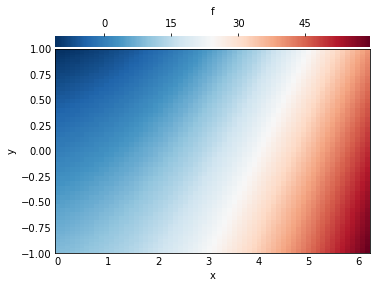

In [56]:
plot_bot_2d(f);

Now let's take a look at the magnitude of the coefficients:

(32, 64)


/home/naveen/anaconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


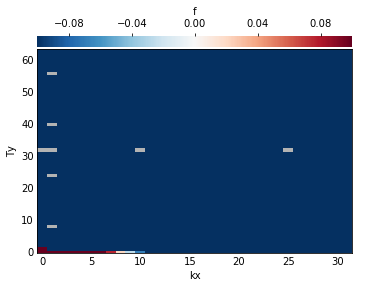

In [57]:
# Convert data to coefficient space by indexing with 'c' key
f['c']
print(f['c'].shape)
# Plot log of magnitude of data
def log_magnitude(xmesh, ymesh, data):
    return xmesh, ymesh, np.log10(np.abs(data))
plot_bot_2d(f, func=log_magnitude);

We can see that the specified function is pretty well-resolved.

In addition to the key interface, we can change the layout of a field using the `require_coeff_space`, `require_grid_space`, `require_layout`, and `require_local` methods.

### Field scale factors

The `set_scales` method is used to change the scaling factors used when transforming field data into grid space.  When setting a field's data using grid arrays, shape errors will result if there is a mismatch between the field and grid's scale factors.

Large scale factors can be used to interpolate the field data onto a high-resolution grid, while small scale factors can be used to view a lower-resolution grid representation of a field.  *Beware: using scale factors less than 1 will result in a loss of data when transforming to grid space.*

Let's take a look at a high-resolution sampling of our field, by increasing the scales.

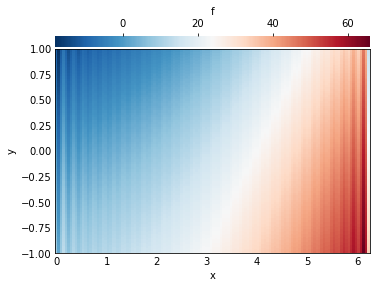

In [31]:
f.set_scales(2)
f['g']
plot_bot_2d(f);

## 2.2: Operators

### Arithmetic with fields

Mathematical operations on fields, such as arithmetic, differentiation, integration, and interpolation, are represented by `operator` classes.  An instance of an operator class represents a specific mathematical operation, and provides an interface for the deferred evaluation of that operation with respect to it's potentially evolving arguments.

Arithmetic operations between fields, or fields and scalars, are produced simply using Python's infix operators for arithmetic.  Let's start with a very simple example of adding a scalar to the field we previously defined.

In [32]:
add_op = 10 + f
add_op

Add(<Scalar 139699919886992>, <Field 139699917768240>)

The object we get is not another field, but an operator object representing the addition of 10 and our field.  To actually compute this operation, we use the `evaluate` method, which returns a new field with the result.  The dealias scale factors set during basis instantiation are used for the evaluation of all operators.

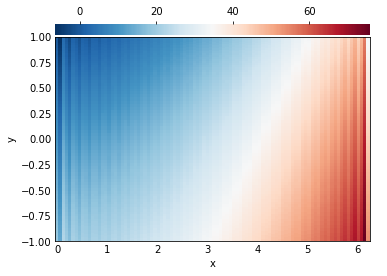

In [33]:
add_result = add_op.evaluate()
add_result.require_grid_space()
plot_bot_2d(add_result);

### Building expressions

Operator instances can be passed as arguments to other operators, building trees that represent more complicated expressions:

In [34]:
tree_op = 2*add_op + f*f
tree_op

Add(Mul(<Scalar 139699919887776>, Add(<Scalar 139699919886992>, <Field 139699917768240>)), Mul(<Field 139699917768240>, <Field 139699917768240>))

Reading these signatures can be a little cumbersome, but we can plot the operator's structure using a helper from dedalus.tools:

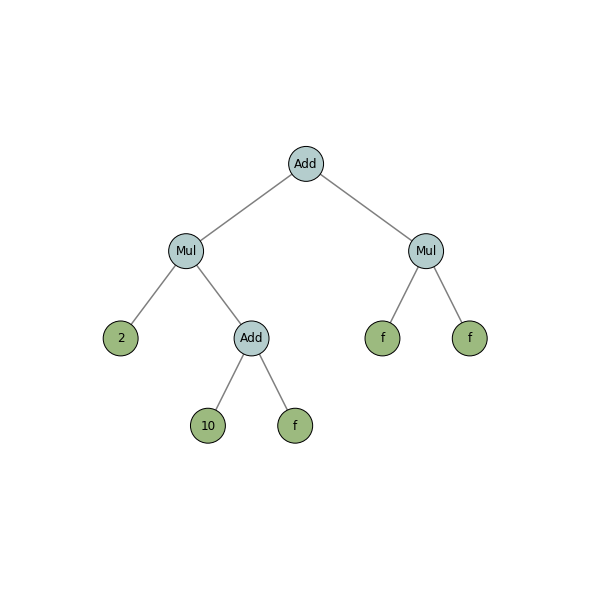

In [35]:
from dedalus.tools.plot_op import plot_operator
plot_operator(tree_op, figsize=8, fontsize=12)

And evaluating it:

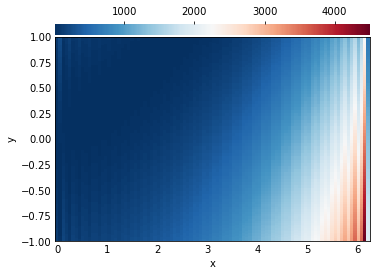

In [36]:
tree_result = tree_op.evaluate()
tree_result.require_grid_space
plot_bot_2d(tree_result);

### Deferred evaluation

A key point is that the operator objects symbolically represent an operation on the field arguments, and are evaluated using deferred evaluation.  If we change the data of the field arguments and re-evaluate an operator, we get a new result.

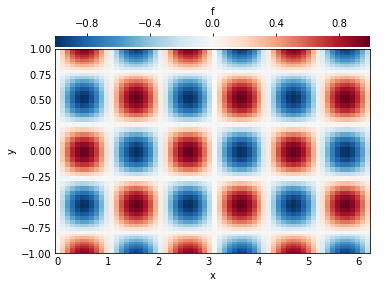

In [37]:
# Set scales back to 1 to build new grid data
f.set_scales('1', keep_data=False)
f['g'] = np.sin(3*x) * np.cos(6*y)
plot_bot_2d(f);

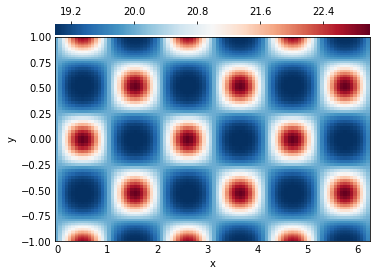

In [15]:
tree_result = tree_op.evaluate()
tree_result.require_grid_space
plot_bot_2d(tree_result);

### Differentiation, integration, interpolation

In addition to arithmetic, operators are used for differentiation, integration, and interpolation.  There are three ways to apply these operators to a field.

First, the operators performing these operations along a given dimension of the data can be accessed through the `basis.Differentiate`, `basis.Integrate`, and `basis.Interpolate` methods of the corresponding basis object.

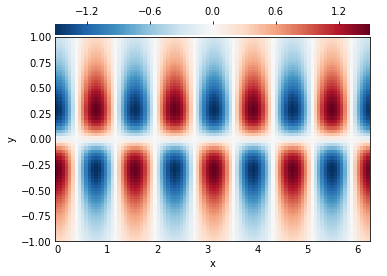

In [16]:
# Let's change the data back to our first example, with a constant offset
f.set_scales('1', keep_data=False)
f['g'] = np.cos(4*x) / np.cosh(3*y) + 1

# Let's setup some operations using the basis operators
fx_op = ybasis.Differentiate(f)
int_f_op = ybasis.Integrate(f)
f0_op = ybasis.Interpolate(f, position=0)

# And we'll just evaluate and plot one of them
fx = fx_op.evaluate()
fx.require_grid_space()
plot_bot_2d(fx);

Second, more general interfaces taking bases as arguments are available through the `operators` module.  The `operators.differentiate` factory allows us to easily construct higher-order and mixed derivatives involving different bases.  The `operators.integrate` and `operators.interpolate` factories allow us to integrate/interpolate along multiple axes, as well.

Total integral: 12.566370614359172
f at (x,y)=(0,0): 1.999999999999973


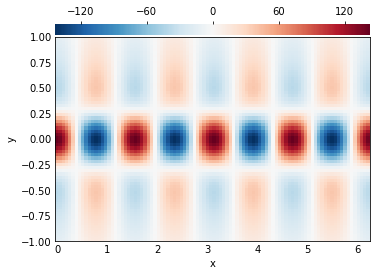

In [17]:
# Some examples using the constructors from the operators module
fxxyy_op = de.operators.differentiate(f, x=2, y=2)
total_int_f_op = de.operators.integrate(f, 'x', 'y')
f00_op = de.operators.interpolate(f, x=0, y=0)

fxxyy = fxxyy_op.evaluate()
total_int_f = total_int_f_op.evaluate()
f00 = f00_op.evaluate()

print('Total integral:', total_int_f['g'][0,0])
print('f at (x,y)=(0,0):', f00['g'][0,0])

fxxyy.require_grid_space()
plot_bot_2d(fxxyy);

Third, the `differentiate`, `integrate`, and `interpolate` field methods provide short-cuts for building and evaluating these operations, directly returning the resulting fields.

Total integral: 12.566370614359172
f at (x,y)=(0,0): 1.999999999999973


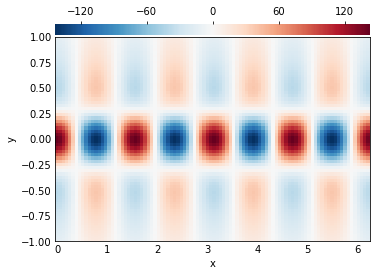

In [18]:
# The same results, directly from field methods
fxxyy = f.differentiate(x=2, y=2)
total_int_f = f.integrate('x', 'y')
f00 = f.interpolate(x=0, y=0)

print('Total integral:', total_int_f['g'][0,0])
print('f at (x,y)=(0,0):', f00['g'][0,0])

fxxyy.require_grid_space()
plot_bot_2d(fxxyy);